In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_columns = 100

# EDA and Data Cleaning


In [2]:
df = pd.read_csv("../data/transfers.csv")

In [3]:
df.head()

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,Ecuador,NaN,RB,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,Senegal,NaN,CF,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,France,Guadeloupe,AM,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,England,NaN,CF,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015


## NA Values


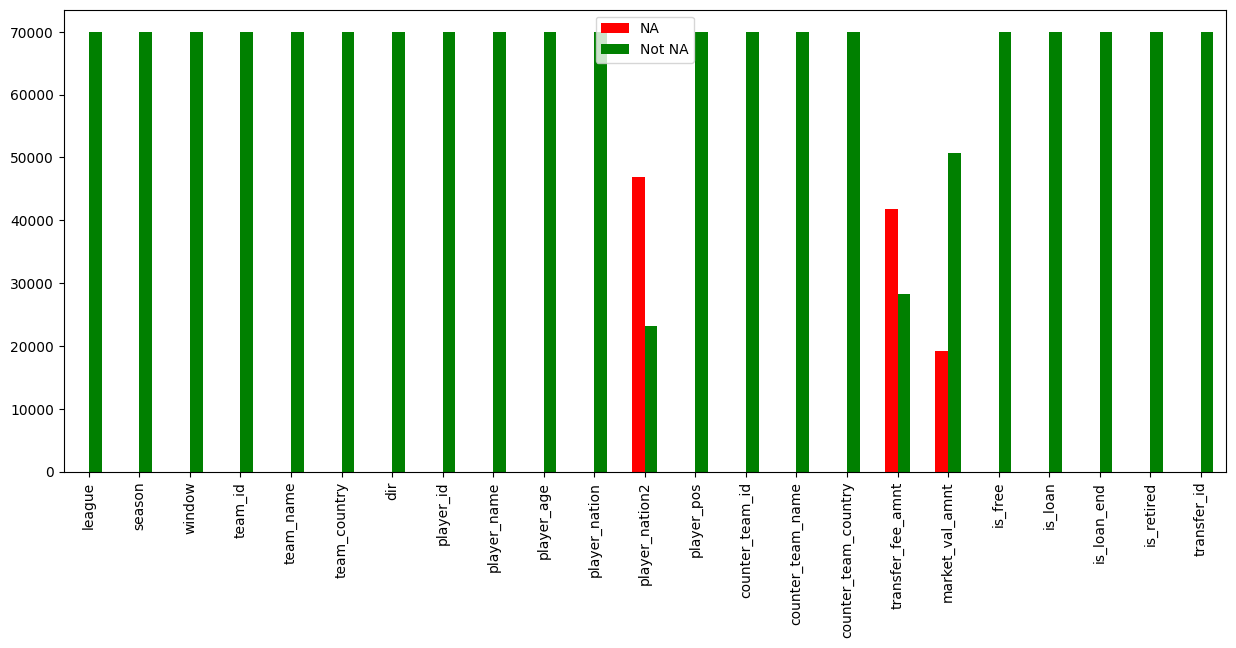

In [4]:
na_counts = df.isna().sum()
not_na_counts = df.notna().sum()
plot_df = pd.DataFrame({"NA": na_counts, "Not NA": not_na_counts}).plot(
    kind="bar", figsize=(15, 6), color=["red", "green"]
)

<Axes: xlabel='is_loan'>

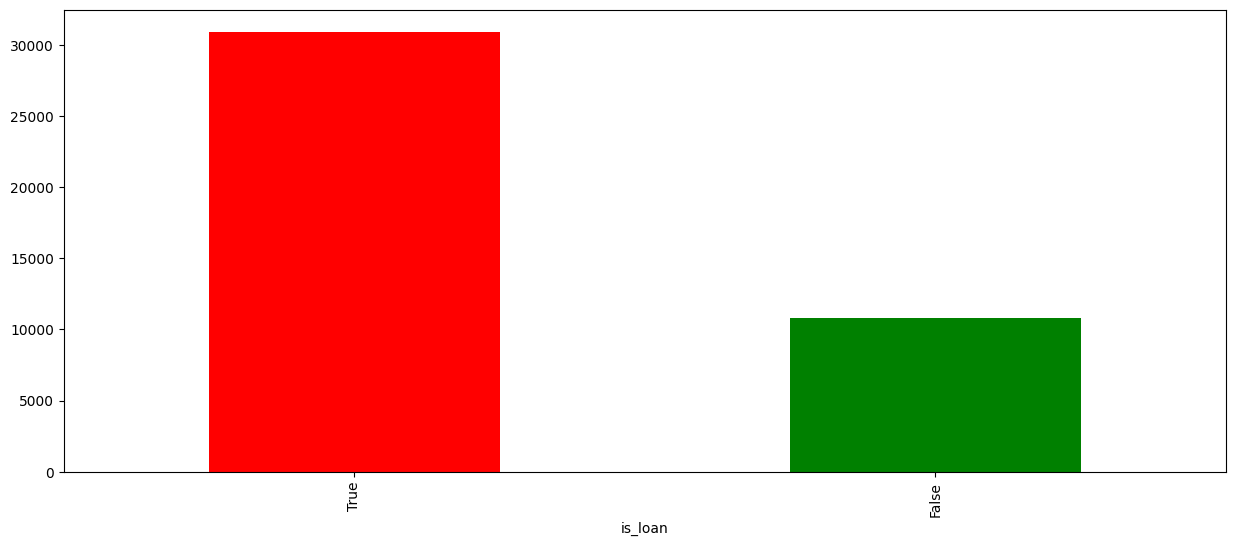

In [5]:
df[df["transfer_fee_amnt"].isna()]["is_loan"].value_counts().plot(
    kind="bar", figsize=(15, 6), color=["red", "green"]
)

In [7]:
df[df["is_loan"] == True]["transfer_fee_amnt"].value_counts(ascending=True)

transfer_fee_amnt
435000.0       1
138000.0       1
34000.0        1
10000.0        1
4750000.0      1
            ... 
100000.0     143
300000.0     143
200000.0     184
1000000.0    264
500000.0     340
Name: count, Length: 177, dtype: int64

In [119]:
# Count number of na in column transfer_fee_ambt per season
df.groupby(["season"])["transfer_fee_amnt"].apply(lambda x: x.isna().sum()).reset_index(
    name="na_count"
).sort_values(by="na_count", ascending=False)

,season,na_count
5,2014,3608
4,2013,3427
10,2019,3408
11,2020,3334
6,2015,3312
8,2017,3270
7,2016,3242
9,2018,3220
3,2012,3170
1,2010,3157


It seems that the NA values for the transfer_fee_amnt are mainly for loans


## Removing duplicates


In [120]:
df[df["transfer_id"] == 308498]

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
12,GB1,2009,s,985,Manchester United,England,left,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,418,Real Madrid,Spain,94000000.0,45000000.0,False,False,False,False,308498
11443,ES1,2009,s,418,Real Madrid,Spain,in,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,985,Manchester United,England,94000000.0,45000000.0,False,False,False,False,308498


In [121]:
transfer_id_count = df.groupby("transfer_id").size()
transfer_id_count

transfer_id
68451      1
86251      1
114133     2
128446     1
128615     1
          ..
3630750    1
3632046    1
3632617    1
3632931    1
3633188    1
Length: 58640, dtype: int64

Some transfers are twice in the dataset, one as a in-transfert and another as a out-transfer. We need to remove one of them.


<Axes: xlabel='dir'>

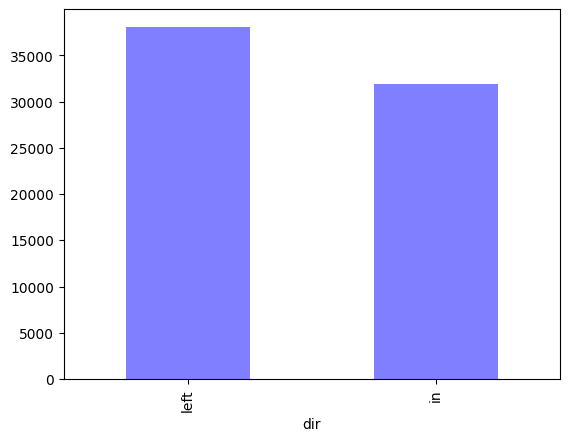

In [122]:
df["dir"].value_counts().plot(kind="bar", color="blue", alpha=0.5)

In [123]:
to_drop = transfer_id_count[transfer_id_count > 1].index
df_in = df[df["dir"] == "in"]
to_drop = df_in[df_in["transfer_id"].isin(to_drop)].index
df = df.drop(to_drop)

<Axes: xlabel='dir'>

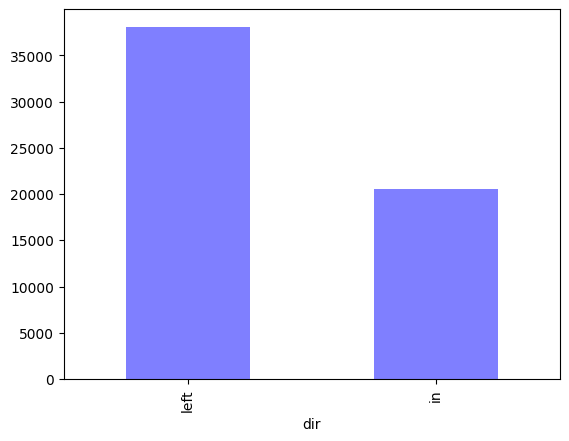

In [124]:
df["dir"].value_counts().plot(kind="bar", color="blue", alpha=0.5)

## Swap to the order of the transfer to only have 'dir' == 'left'


In [125]:
df_in.head(5)

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,Ecuador,NaN,RB,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,Senegal,NaN,CF,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,France,Guadeloupe,AM,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,England,NaN,CF,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015


In [126]:
df_out = df[df["dir"] == "left"]
df_in = df[df["dir"] == "in"]

swap_map = {
    "team_id": "counter_team_id",
    "team_name": "counter_team_name",
    "team_country": "counter_team_country",
}
swap_map.update({v: k for k, v in swap_map.items()})
df_in = df_in.rename(columns=swap_map)
df_in = df_in[df_out.columns]  # Keep the same col order

In [127]:
df_in.head(5)

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
1,GB1,2009,s,687,Molde FK,Norway,in,62049,Mame Diouf,21.0,Senegal,NaN,CF,985,Manchester United,England,4500000.0,1600000.0,False,False,False,False,319841
3,GB1,2009,s,762,Newcastle United,England,in,1397,Michael Owen,29.0,England,NaN,CF,985,Manchester United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,5242,Manchester United U18,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,985,Manchester United,England,NaN,NaN,False,False,False,False,339015
6,GB1,2009,s,2962,Altrincham FC,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,985,Manchester United,England,NaN,NaN,False,True,True,False,351895
7,GB1,2009,s,2262,Plymouth Argyle,England,in,73482,James Chester,20.0,Wales,England,CB,985,Manchester United,England,NaN,1200000.0,False,True,True,False,373518


In [128]:
df = pd.concat([df_out, df_in], ignore_index=True).drop(columns=["dir"])
df

,league,season,window,team_id,team_name,team_country,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,418,Real Madrid,Spain,94000000.0,45000000.0,False,False,False,False,308498
1,GB1,2009,s,985,Manchester United,England,42411,Fraizer Campbell,21.0,England,Jamaica,CF,289,Sunderland AFC,England,4100000.0,700000.0,False,False,False,False,316117
2,GB1,2009,s,985,Manchester United,England,64484,Manucho,26.0,Angola,Portugal,CF,366,Real Valladolid CF,Spain,2750000.0,NaN,False,False,False,False,320029
3,GB1,2009,s,985,Manchester United,England,15449,Lee Martin,22.0,England,NaN,AM,677,Ipswich Town,England,2250000.0,250000.0,False,False,False,False,314073
4,GB1,2009,s,985,Manchester United,England,34130,Tom Heaton,23.0,England,NaN,GK,1039,Queens Park Rangers,England,NaN,1000000.0,False,True,False,False,333026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58635,NL1,2021,s,7006,Melbourne Victory,Australia,480022,Dylan Ryan,21.0,Australia,NaN,CB,403,Willem II Tilburg,Netherlands,NaN,125000.0,False,True,True,False,3136068
58636,NL1,2021,w,515,Without Club,Without Club,140032,Andreas Samaris,32.0,Greece,NaN,DM,385,Fortuna Sittard,Netherlands,NaN,1500000.0,False,False,False,False,3633188
58637,NL1,2021,w,1293,Tromsø IL,Norway,257808,Runar Espejord,25.0,Norway,NaN,CF,306,SC Heerenveen,Netherlands,NaN,500000.0,False,True,True,False,3071862
58638,NL1,2021,w,37535,Montevideo City Torque,Uruguay,580142,Joaquín Fernández,22.0,Uruguay,Italy,CB,306,SC Heerenveen,Netherlands,NaN,100000.0,False,True,True,False,3268245


## Aggregate the data to club leveL


In [18]:
grouping_cols = [
    "team_id",
    "counter_team_id",
    "team_name",
    "counter_team_name",
    "team_country",
    "counter_team_country",
]
agg_dict = {
    "transfer_fee_amnt": "sum",
}
df_club = df.groupby(grouping_cols).agg(agg_dict).reset_index()
df_club = df_club.rename(columns={"transfer_fee_amnt": "total_fee"})
df_club

,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee
0,2,1,1.FC Kaiserslautern,1.FC Saarbrücken,Germany,Germany,0.0
1,2,10,1.FC Kaiserslautern,Arminia Bielefeld,Germany,Germany,0.0
2,2,1017,1.FC Kaiserslautern,Hapoel Tel Aviv,Germany,Israel,3250000.0
3,2,1277,1.FC Kaiserslautern,FC Schaffhausen,Germany,Switzerland,0.0
4,2,129,1.FC Kaiserslautern,SG Dynamo Dresden,Germany,Germany,0.0
...,...,...,...,...,...,...,...
27770,23826,9572,RB Leipzig,BSG Chemie Leipzig,Germany,Germany,0.0
27771,23826,969,RB Leipzig,Montpellier HSC,Germany,France,16000000.0
27772,23826,984,RB Leipzig,West Bromwich Albion,Germany,England,15200000.0
27773,23826,995,RB Leipzig,FC Nantes,Germany,France,0.0


There seem to be some particular rows in the dataset, some player appear twice during the same season but it is because of loans. Some loans are free and some are paid.


## Number of player per player_pos


In [ ]:
subset = df[df["season"] == 2021]

In [16]:
def count_player_positions(group):
    """
    Count the number of players in each position for a given group.
    """
    return group["player_pos"].value_counts()

In [19]:
df_pos = subset.groupby(grouping_cols).apply(count_player_positions).reset_index()
df_pos = df_pos.pivot_table(
    index=["team_name", "counter_team_name"],
    columns="player_pos",
    values="count",
    fill_value=0,
    aggfunc="sum",
)
df_pos = df_pos.reset_index()
df_pos

player_pos,team_name,counter_team_name,AM,CB,CF,CM,DM,GK,LB,LM,LW,RB,RM,RW,SS,midfield
0,1. FC Köln,1.FC Köln II,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1. FC Köln,1.FSV Mainz 05,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2,1. FC Köln,AS Monaco,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1. FC Köln,AS Saint-Étienne,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1. FC Köln,Aarhus GF,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,Wolverhampton Wanderers,Sevilla FC,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3131,Wolverhampton Wanderers,Sheffield United,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3132,Wolverhampton Wanderers,Sporting CP,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3133,Wolverhampton Wanderers,St. Mirren FC,0,0,0,2,0,0,0,0,0,0,0,0,0,0
